In [1]:
### Import libraries

%matplotlib inline
import xarray as xr
import cmocean as cmo
import pandas as pd
from glob import glob

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

import cartopy
import cartopy.crs as ccrs

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# General settings and preparation

In [2]:
### Define functions for preparation of data and plotting

def divide_longitude(lons, lats, var):
    '''
    Split data into sections east and west of the prime meridian.
    
    Parameters:
    ---
    lons (array): longitudes
    lats (array): latitudes
    var (array): variable data associated with the latitudes and longitudes
        
    Returns:
    ---
    lons_greater (array): longitudes east of the prime meridian (0 to 180°)
    lons_lesser (array): longitudes west of the prime meridian (-180 to 0°)
    lats_greater (array): latitudes corresponding to lons_greater
    lats_lesser (array): latitudes corresponding to lons_lesser
    var_greater (array): variable data corresponding to lons_greater
    var_lesser (array): variable data corresponding to lons_lesser
    '''
    
    # Mask based on longitudes
    lons_greater = ma.masked_greater(lons, -0.01)
    lons_lesser = ma.masked_less(lons, 0.)
    
    lats_greater = ma.MaskedArray(lats, mask=lons_greater.mask)
    lats_lesser = ma.MaskedArray(lats, mask=lons_lesser.mask)
    
    var_greater = ma.MaskedArray(var, mask=lons_greater.mask)
    var_lesser = ma.MaskedArray(var, mask=lons_lesser.mask)
    
    return lons_greater, lons_lesser, lats_greater, lats_lesser, var_greater, var_lesser

In [3]:
### Settings circular boundary South Polar Stereo projection plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [4]:
### Base path to files
base_path = '/nethome/5867800/'

In [5]:
### Locations

# ODP Site 696
x696_pd, y696_pd = -42.933067, -61.849083   # present-day coordinates [°]
x696_le, y696_le = -57., -67.5              # late Eocene coordinates (determined visually) [°]

# Gridcell distance
gcd = (np.deg2rad(0.1)*6371e3)              # gridcell distance [m]

# Backwards release locations [°]
lons_bw = np.array([-57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                    -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                    -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                    -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                    -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221])
lats_bw = np.array([-67.5270462, -67.5270462, -67.5270462, -67.5270462, -67.5270462,
                    -67.5164814, -67.5164814, -67.5164814, -67.5164814, -67.5164814,
                    -67.5059166, -67.5059166, -67.5059166, -67.5059166, -67.5059166,
                    -67.49535179, -67.49535179, -67.49535179, -67.49535179, -67.49535179,
                    -67.48478699, -67.48478699, -67.48478699, -67.48478699, -67.48478699])

In [6]:
### Prepare bathymetric data

# Load data Nooteboom et al. (2022)
topo = xr.open_dataset(base_path + 'grid/adapted_bathymetry.nc')

# Load latitudes, longitudes and bathymetry
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(topo.variables['T_LON_2D'][:,:], topo.variables['T_LAT_2D'][:,:], topo.variables['Bathymetry'][:,:])
lons = np.concatenate((lonsg[:,2650:], lonsg[:,:850], lonsl[:,850:2650]), axis=1)   # -179.95 to -85.05, -84.95 to -0.05, 0.05 to 179.95
lats = np.concatenate((latsg[:,2650:], latsg[:,:850], latsl[:,850:2650]), axis=1)
bath = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)

# Figures backwards simulations

First, load and prepare the data of the backwards simulations.

Start with the main simulations, which consist of depth-integrated simulations for the three smallest iceberg size classes (C1-C3), and a simulation for iceberg size class C1 using only surface fields.

In [7]:
### Load data of main backwards simulations
C1b = xr.open_zarr(base_path + 'active/25p_5y_int_30d_1hdtar_C1_bw.zarr')    # no grounding, C1 (L=10m)
C2b = xr.open_zarr(base_path + 'active/25p_5y_int_30d_1hdtar_C2_bw.zarr')    # no grounding, C2 (L=100m)
C3b = xr.open_zarr(base_path + 'active/25p_5y_int_30d_1hdtar_C3_bw.zarr')    # no grounding, C3 (L=1000m)
SB  = xr.open_zarr(base_path + 'active/25p_5y_surf_30d_1hdtar_C1.zarr')      # surface w/o grounding, C1 (L=10m)

The simulations described in the supplementary file consist of a simulation of passive particles at the surface, and depth-integrated simulations for icebergs of size class C1 with a southwestward shift in the location of ODP Site 696 and of iceberg size class C1 using the adapted basal melt equation as described in the supplements.

In [8]:
### Load data supplementary backwards simulations
PB  = xr.open_zarr(base_path + 'passive/25p_5y_30d_1hdtar_bw.zarr')          # passive
C1s = xr.open_zarr(base_path + 'active/25p_5y_int_30d_1hdtar_C1s.zarr')      # no grounding, C1 changed loc (10) 
C1a = xr.open_zarr(base_path + 'active/25p_5y_int_30d_1hdtar_C1a.zarr')      # no grounding, C1 adapted melt (10)  

## Minimum values

Now, determine the minimum values of iceberg mass and thickness.

Start with the main simulations.

In [9]:
### Load data
data = [C1b, C2b, C3b, SB]
names = ['C1', 'C2', 'C3', 'SB']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', 'C1 icebergs - surface only']

In [10]:
### Calculate the minimum iceberg mass and thickness of each simulation
for dat, name in zip(data, names):
    if name != '-':
        masked_dat = dat.where(dat['reg']>=2, drop=False)        # select only the coastal regions from Palmer Land till Dronning Maud Land
        print(f'Start calculating minimum values {name}...')
        mmin = np.nanmin(masked_dat['M'].values)/1e9             # convert to Mt
        tmin = np.nanmin(masked_dat['z'].values*(1027.5/850.))   # calculate thickness from iceberg draft and densities of seawater and ice
        print(f"   mass: {mmin:3.3f}, thickness: {tmin:3.3f}")

Start calculating minimum values C1...
   mass: 5.563, thickness: 14.187
Start calculating minimum values C2...
   mass: 8.740, thickness: 21.157
Start calculating minimum values C3...
   mass: 373.804, thickness: 203.827
Start calculating minimum values SB...
   mass: 5.226, thickness: 13.579


Similarly for the supplementary simulations.

In [11]:
### Load data
data_sup = [PB, C1s, C1a]
names_sup = ['PB', 'C1s', 'C1a']
labels_sup = ['Passive particles', 'C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

In [12]:
### Calculate the minimum iceberg mass and thickness of each simulation
for dat, name in zip(data_sup[1:], names_sup[1:]):
    if name != '-':
        masked_dat = dat.where(dat['reg']>=2, drop=False)        # select only the coastal regions from Palmer Land till Dronning Maud Land
        print(f'Start calculating minimum values {name}...')
        mmin = np.nanmin(masked_dat['M'].values)/1e9             # convert to Mt
        tmin = np.nanmin(masked_dat['z'].values*(1027.5/850.))   # calculate thickness from iceberg draft and densities of seawater and ice
        print(f"   mass: {mmin:3.3f}, thickness: {tmin:3.3f}")

Start calculating minimum values C1s...
   mass: 4.764, thickness: 13.706
Start calculating minimum values C1a...
   mass: 5.563, thickness: 14.187


## Number of points per region

Next, calculate the number of data points in each coastal region (Palmer Land, Ellsworth Mountains, Filchner Ice Shelf, Coats Land, Dronning Maud Land west and east).

Main simulations: Appendix B, Table B1

In [13]:
for dat, name in zip(data, names):
    print(f'For {name}:')
    points = np.unique(dat.reg, return_counts=True)
    print(f'   regions: {points[1][3:]}')
    print(f'   total: {points[1][3:].sum()}')

For C1:
   regions: [5043 3269 2494  350   65    8]
   total: 11229
For C2:
   regions: [5642 4332 3386  344   25   10]
   total: 13739
For C3:
   regions: [24511 43157 32756 19348  2638   247]
   total: 122657
For SB:
   regions: [3896 1580 1453  243   42    9]
   total: 7223


Supplements: Table S3.2

In [14]:
for dat, name in zip(data_sup, names_sup):
    print(f'For {name}:')
    points = np.unique(dat.reg, return_counts=True)
    print(f'   regions: {points[1][3:]}')
    print(f'   total: {points[1][3:].sum()}')

For PB:
   regions: [3792 1554 1294  164   31   11]
   total: 6846
For C1s:
   regions: [5869 3540 3064  340   59    2]
   total: 12874
For C1a:
   regions: [5043 3269 2494  350   65    3]
   total: 11224


## Prepare data for plotting

Finally, prepare the data for plotting by creating dataframes with the iceberg mass, iceberg thickness and coastal region.

Start with the main simulations.

In [15]:
i=0
for dat, name in zip(data, names):
    print(f'Start preparing {name}...')
    
    ### Select coastal regions (Palmer Land till Dronning Maud Land)
    reg_bool = dat['reg']>=2

    ### Find the last index of 'True' and replace rows with only 'False' with nan
    first_true_idx = np.argmax(np.fliplr(reg_bool)==True, axis=1)
    last_true_idx = (np.fliplr(reg_bool).shape[1] - first_true_idx - 1).astype(np.float64)
    last_true_idx[np.all(reg_bool == False, axis=1)] = np.nan
    
    c = last_true_idx+1.
    
    ### Study temporal evolution till last point in coastal region
    # Define arrays (mass, depth, region)
    evom = np.ones((len(c),len(dat['obs']))) * np.nan
    evod = np.ones((len(c),len(dat['obs']))) * np.nan
    evor = np.ones((len(c),len(dat['obs']))) * np.nan
    
    # Select relevant values
    print(f'   start masking...')
    mask = np.arange(evom.shape[1]) < c[:, None]
    
    # Assign values to arrays
    evom[mask] = (dat['M'].values)[mask]   # [kg]
    evod[mask] = (dat['z'].values)[mask]
    evor[mask] = (dat['reg'].values)[mask]
    
    # Calculate iceberg thickness
    evot = evod*(1027.5/850.)
    
    ### Create dataframe containing iceberg mass, thickness and coastal region
    print(f'   start dataframe...')
    seldata = pd.DataFrame(data={'mass': evom.flatten()*(1e-9),   # Convert to [Mt]
                                 'thickness': evot.flatten(),     # [m]
                                 'region': evor.flatten()})       # [-]
    # Save dataframes
    if i==0:
        prep0 = seldata
    elif i==1:
        prep1 = seldata
    elif i==2:
        prep2 = seldata
    elif i==3:
        prep3 = seldata
    
    i +=1
print('done')

Start preparing C1...
   start masking...
   start dataframe...
Start preparing C2...
   start masking...
   start dataframe...
Start preparing C3...
   start masking...
   start dataframe...
Start preparing SB...
   start masking...
   start dataframe...
done


In [16]:
### Reload data
preps = [prep0, prep1, prep2, 0, prep3, 0]
names = ['C1', 'C2', 'C3', '-', 'C2s', '-']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', '-', 'C1 icebergs - surface only', '-']

And finally the supplementary simulations.

In [17]:
i=0
for dat, name in zip(data_sup[1:], names_sup[1:]):
    print(f'Start preparing {name}...')

    ### Select coastal regions
    reg_bool = dat['reg']>=2

    ### Find the last index of 'True' and replace rows with only 'False' with nan
    first_true_idx = np.argmax(np.fliplr(reg_bool)==True, axis=1)
    last_true_idx = (np.fliplr(reg_bool).shape[1] - first_true_idx - 1).astype(np.float64)
    last_true_idx[np.all(reg_bool == False, axis=1)] = np.nan

    c = last_true_idx+1.

    ### Study temporal evolution till last point in coastal region
    # Define arrays (mass, depth, region)
    evom = np.ones((len(c),len(dat['obs']))) * np.nan
    evod = np.ones((len(c),len(dat['obs']))) * np.nan
    evor = np.ones((len(c),len(dat['obs']))) * np.nan

    # Select relevant values
    print(f'   start masking...')
    mask = np.arange(evom.shape[1]) < c[:, None]

    # Assign values to arrays
    evom[mask] = (dat['M'].values)[mask]   # [kg]
    evod[mask] = (dat['z'].values)[mask]
    evor[mask] = (dat['reg'].values)[mask]

    # Calculate iceberg thickness
    evot = evod*(1027.5/850.)

    ### Create dataframe containing iceberg mass, thickness and coastal region
    print(f'   start dataframe...')
    seldata = pd.DataFrame(data={'mass': evom.flatten()*(1e-9),   # Convert to [Mt]
                                 'thickness': evot.flatten(),     # [m]
                                 'region': evor.flatten()})       # [-]
    
    # Save dataframes
    if i==0:
        prep4 = seldata
    elif i==1:
        prep5 = seldata
    
    i +=1
print('done')

Start preparing C1s...
   start masking...
   start dataframe...
Start preparing C1a...
   start masking...
   start dataframe...
done


In [18]:
### Reload data
preps_sup = [prep4, prep5]
names_sup = ['C1s', 'C1a']
labels_sup = ['C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

Define plotting properties:

In [19]:
### Set colours
cols_carter = ['#d2d3d4','#ada4ce','#e5a787','#cc393c','#d578aa','#d6c7d0']   # colourscheme from regions used in Carter et al. (2014)

In [20]:
### Define axis style for violin plots
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Region', fontsize=13)

In [21]:
### Define region labels
labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

## Iceberg mass

We are interested in the iceberg mass obtained from the backwards trajectories. We can analyse this by looking at the distribution per coastal region and the spatial spread.

### Coastal region

First, study the distribution of the obtained (minimum) iceberg masses in each coastal region using violinplots.

Main simulations: Figure 6a

Plot C1...
Plot C2...
Plot C3...
Plot C2s...
Saving figures...


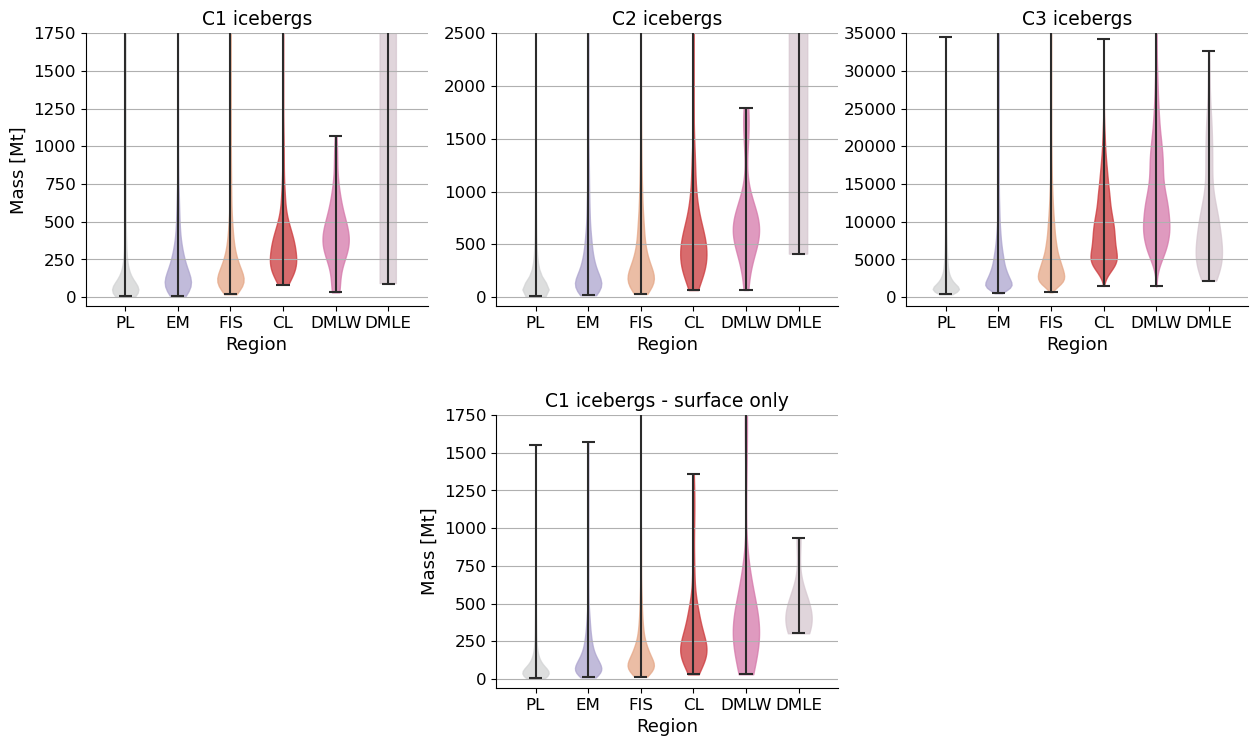

In [22]:
### Study mass distribution in each coastal region

# Prepare axes
fig = plt.figure(figsize=(15,8.5))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])                                          # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

# Plot mass ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')
        
        # Plot data
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # fill in values far outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]', fontsize=13)
            
        if i==2:
            ax.set_ylim(-35000/30., 35000)
        elif i==1:
            ax.set_ylim(-2500/30., 2500)
        else:
            ax.set_ylim(-1750/30, 1750)
        ax.tick_params(axis='y', which='both', labelsize=12)

        ax.spines[['right', 'top']].set_visible(False)   # hide right and top spines

    else:
        fig.delaxes(ax)   # remove axes for empty plots
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Paper/F06aMinMassRegions.pdf', bbox_inches='tight', dpi=300)
plt.show()

Main simulations: Appendix C - Figure a

Plot C1...
Plot C2...
Plot C3...
Plot C2s...
Saving figures...


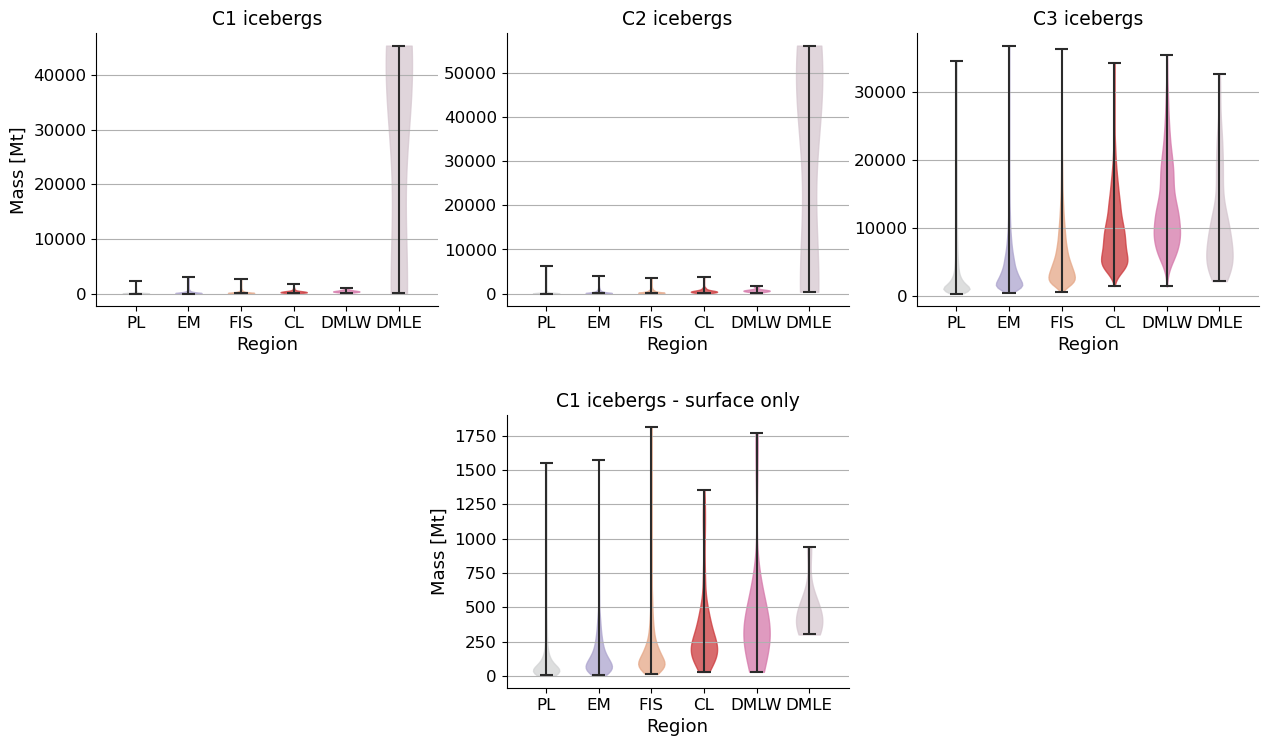

In [23]:
### Study mass distribution in each coastal region - total range

# Prepare axes
fig = plt.figure(figsize=(15,8.5))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])                                          # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

# Plot mass ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # fill in values far outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]', fontsize=13)
        ax.tick_params(axis='y', which='both', labelsize=12)

        ax.spines[['right', 'top']].set_visible(False)   # hide right and top spines

    else:
        fig.delaxes(ax)   # remove axes for empty plots
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Paper/FCaMinMassRegionsFull.pdf', bbox_inches='tight', dpi=300)
plt.show()

Study the lower range in more detail.

Plot C1...
Plot C2...
Plot C3...
Plot C2s...


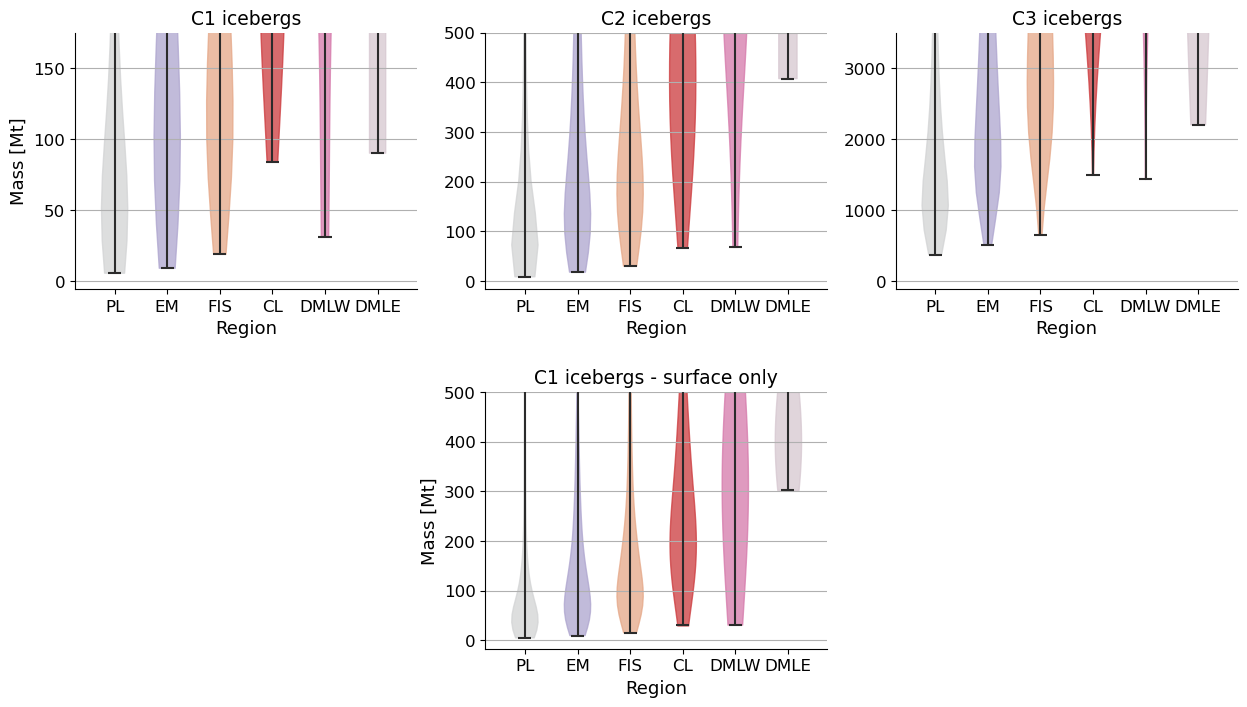

In [24]:
### Study mass distribution in each coastal region - total range

# Prepare axes
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])                                          # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

# Plot mass ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # fill in values far outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]', fontsize=13)
            
        if i==2:
            ax.set_ylim(-3500/30., 3500)
        elif i==1 or i==4:
            ax.set_ylim(-500/30., 500)
        else:
            ax.set_ylim(-175/30, 175)            
        ax.tick_params(axis='y', which='both', labelsize=12)
        
        ax.spines[['right', 'top']].set_visible(False)   # hide right and top spines

    else:
        fig.delaxes(ax)   # remove axes for empty plots
    
    i += 1

plt.show()

Supplements: Figure S3.4a

Plot C1s...
Plot C1a...
Saving figures...


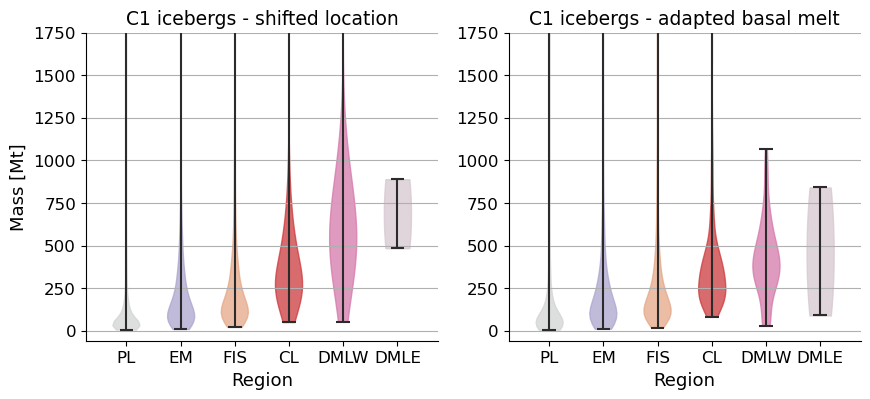

In [25]:
### Study mass distribution in each coastal region

# Prepare axes
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1) # figure: 1 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1))
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1])]

# Plot mass ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps_sup, names_sup, labels_sup, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # fill in values far outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0:
            ax.set_ylabel('Mass [Mt]', fontsize=13)
            
        ax.set_ylim(-1750/30, 1750)                    
        ax.tick_params(axis='y', which='both', labelsize=12)
        
        ax.spines[['right', 'top']].set_visible(False) # hide right and top spines

    else:
        fig.delaxes(ax)   # remove axes for empty plots
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Paper/FS06aMinMassRegions.pdf', bbox_inches='tight', dpi=300)
plt.show()

Study the lower range in more detail.

Plot C1s...
Plot C1a...


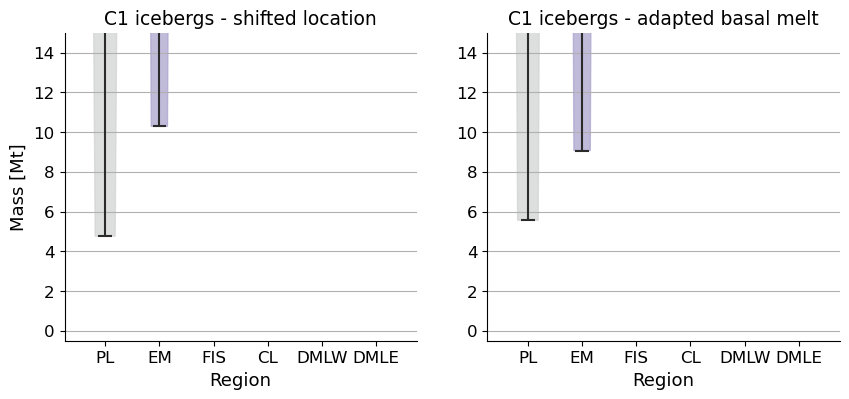

In [26]:
### Study mass distribution in each coastal region

# Prepare axes
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1) # figure: 1 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1))
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1])]

# Plot mass ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps_sup, names_sup, labels_sup, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # fill in values far outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0:
            ax.set_ylabel('Mass [Mt]', fontsize=13)
            
        ax.set_ylim(-15/30, 15)                    
        ax.tick_params(axis='y', which='both', labelsize=12)

        ax.spines[['right', 'top']].set_visible(False) # hide right and top spines

    else:
        fig.delaxes(ax)   # remove axes for empty plots
    
    i += 1

plt.show()

### Spatially

Now, study the distribution of the obtained (minimum) iceberg masses along the coast.

Main simulations: Figure 5a

In [27]:
### Load data
data = [C1b, C2b, C3b, 0, SB, 0]
names = ['C1', 'C2', 'C3', '-', 'SB', '-']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', '-', 'C1 icebergs - surface only', '-']

Start preparing C1...
   and plot...
Start preparing C2...
   and plot...
Start preparing C3...
   and plot...
Start preparing SB...
   and plot...
Saving figures...


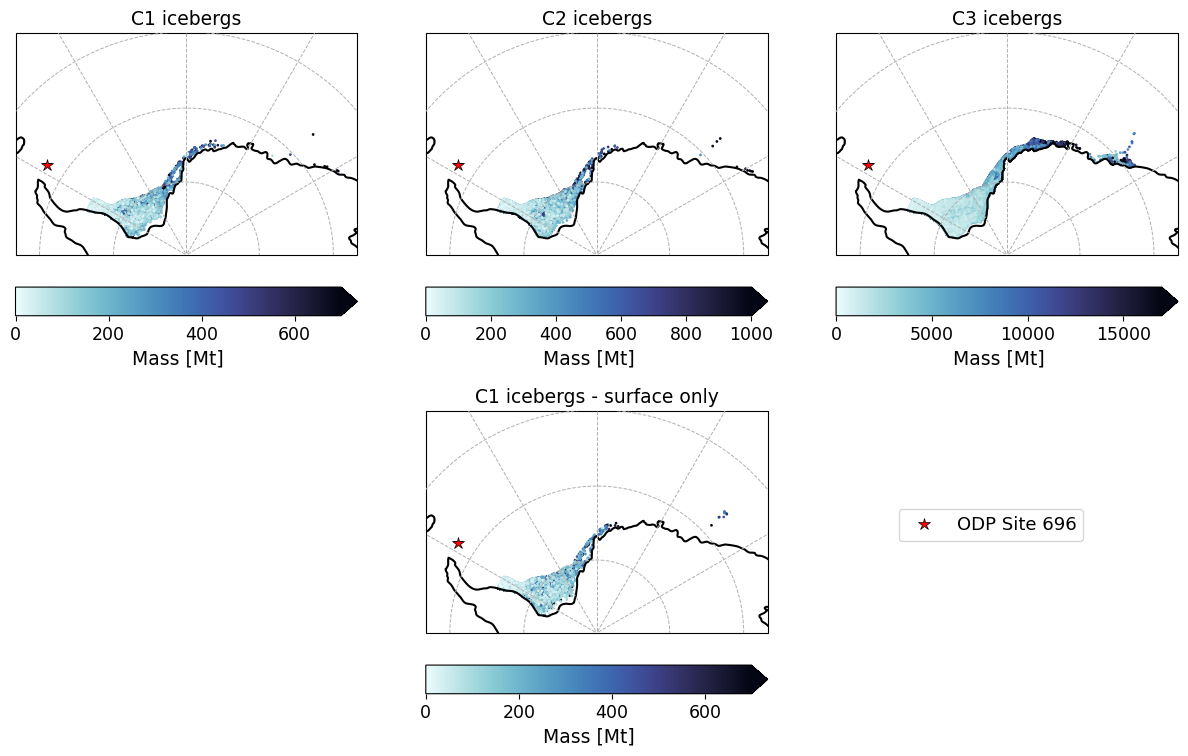

In [28]:
### Study mass distribution spatially

# Prepare axes
fig = plt.figure(figsize=(15,9))

gs = GridSpec(2, 1, height_ratios=[1,1])                                                      # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1),
                              wspace=0.2, width_ratios=(1, 1, 1))                             # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[1], hspace=0.0, height_ratios=(1, 0.1),
                              wspace=0.2, width_ratios=(1, 1, 1))                             # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1], gs0[1,2], gs1[1,0], gs1[1,1], gs1[1,2])]

# Plot mass per simulation
for dat, name, label, ax, c_ax in zip(data, names, labels, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        # Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        # ODP 696
        ax.plot(x696_le, y696_le, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(),
                zorder=2)
        
        # Coastlines
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(),
                   colors='k', zorder=1)
        ax.scatter(1, -78.38, transform=ccrs.PlateCarree(), color='white', zorder=2, s=15)

        # Data
        if name=='C2':
            normalize = colors.Normalize(vmin=0, vmax=1000.)
        elif name=='C3':
            normalize = colors.Normalize(vmin=0, vmax=17000.)
        else:
            normalize = colors.Normalize(vmin=0, vmax=700.)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=masked_dat['M'].values/1e9,
                        transform=ccrs.PlateCarree(), linewidth=.8, s=1.3, cmap=cmo.cm.ice_r, zorder=0, norm=normalize, rasterized=True)
        cbar = plt.colorbar(cf, cax=c_ax, orientation='horizontal', extend='max')
        cbar.set_label(label=r'Mass [Mt]', size=13.5) # 1 Mt = 10E8 kg
        cbar.ax.tick_params(labelsize=12.5)
        
        
        # Gridlines
        # -60, -30, 0, 30, 60 W/E
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])
        # 90, 80, 70, 60, 50 S
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))
        
        # Plot settings
        ax.set_title(f'{str(label)}', fontsize=13.5)

        if name == 'SB':
            handles, labels = ax.get_legend_handles_labels()
            ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                         markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
            handles.append(ODP)
            ax.legend(handles=handles, bbox_to_anchor=(1.95, .6), fontsize='13')
        
    else:   # remove axes for empty plots
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Paper/F05aMinMassSpatial.pdf', bbox_inches='tight', dpi=300)
plt.show()

Supplements: Figure S3.3a

In [29]:
### Load data
data_sup = [C1s, C1a]
names_sup = ['C1s', 'C1a']
labels_sup = ['C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

Start preparing C1s...
   and plot...
Start preparing C1a...
   and plot...
Saving figures...


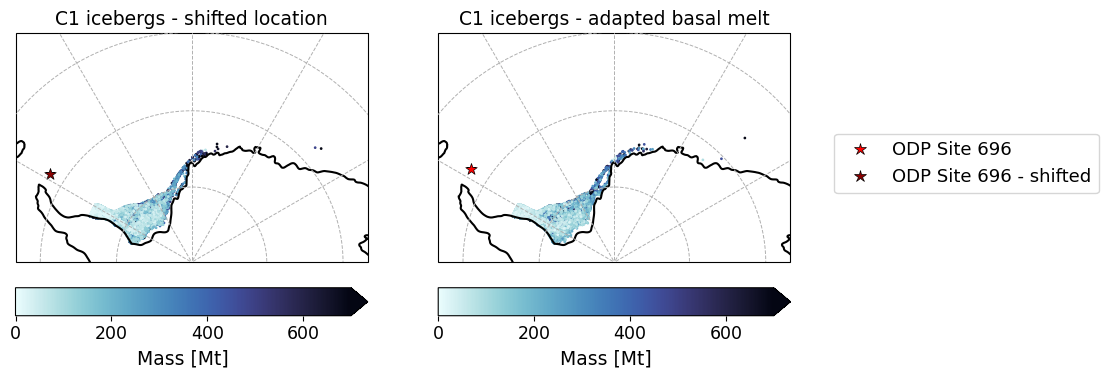

In [30]:
### Study mass distribution spatially

# Prepare axes
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1)
gs0 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1))
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1])]

# Plot mass per simulation
for dat, name, label, ax, c_ax in zip(data_sup, names_sup, labels_sup, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        # Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        # ODP 696
        if name == 'C1s':
            ax.scatter(x696_le-1, y696_le-0.5, color='darkred', marker='*', s=75, edgecolor='k', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        else:
            ax.scatter(x696_le, y696_le, color='r', marker='*', s=75, edgecolor='k', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        
        # Coastlines
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(),
                   colors='k', zorder=1)
        ax.scatter(1, -78.38, transform=ccrs.PlateCarree(), color='white', zorder=2, s=15)
        
        # Data
        normalize = colors.Normalize(vmin=0, vmax=700.)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=masked_dat['M'].values/1e9, transform=ccrs.PlateCarree(),
                        linewidth=.8, s=1.3, cmap=cmo.cm.ice_r, zorder=0, norm=normalize, rasterized=True)
        cbar = plt.colorbar(cf, cax=c_ax, orientation='horizontal', extend='max')
        cbar.set_label(label=r'Mass [Mt]', size=13.5) # 1 Mt = 10E8 kg
        cbar.ax.tick_params(labelsize=12.5)

        # Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])
        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        # Plot settings
        ax.set_title(f'{str(label)}', fontsize=13.5)
        
        if name == 'C1a':
            handles, labels = ax.get_legend_handles_labels()
            ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                         markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
            handles.append(ODP)
            ODPs = Line2D([0], [0], label='ODP Site 696 - shifted', marker='*', markersize=np.sqrt(75),
                         markeredgecolor='k', markerfacecolor='darkred', markeredgewidth=.5, linestyle='')
            handles.append(ODPs)
            ax.legend(handles=handles, bbox_to_anchor=(1.9, .6), fontsize='13')
        
    else:   # remove axes for empty plots
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Paper/FS04aMinMassSpatial.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Iceberg thickness

As for mass, we are interested in the iceberg thickness obtained from the backwards trajectories. We can analyse this by looking at the distribution per coastal region and the spatial spread.

### Coastal region

Again, first study the distribution of the obtained (minimum) iceberg thickness in each coastal region using violinplots.

Main simulations: Figure 6b

Plot C1...
Plot C2...
Plot C3...
Plot C2s...
Saving figures...


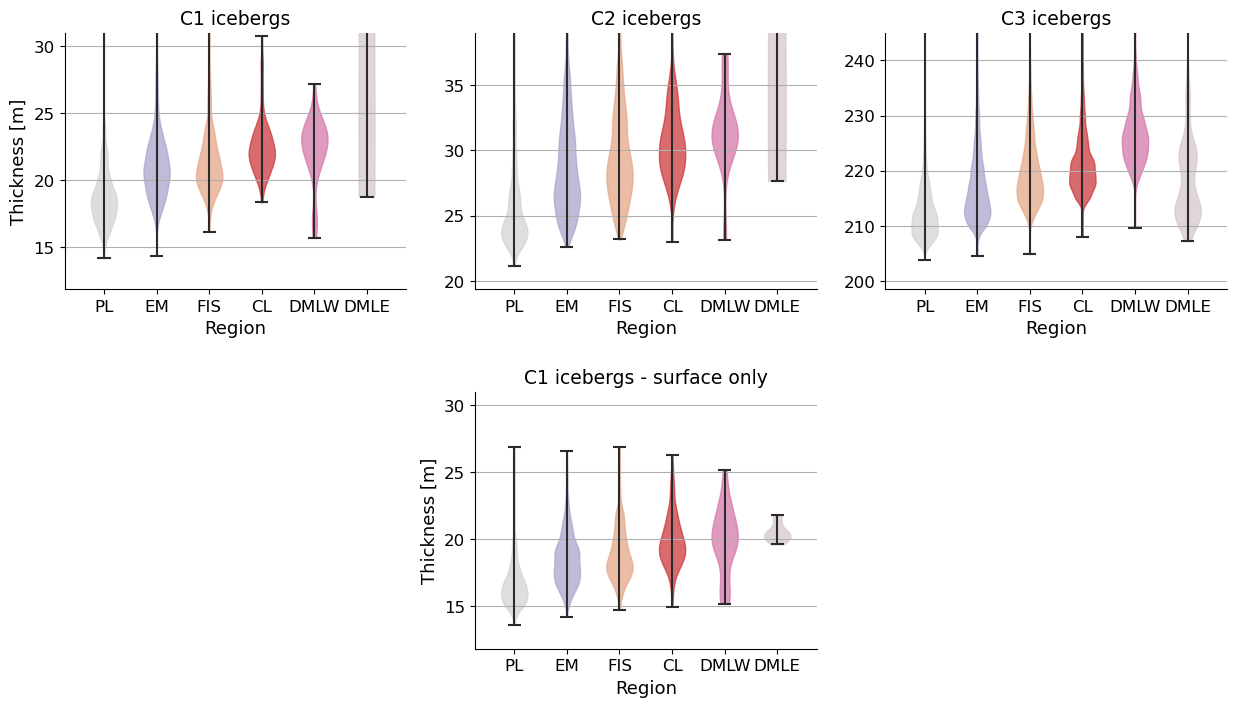

In [31]:
### Study thickness distribution in each coastal region

# Prepare axes
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])                                          # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

# Plot thickness ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['thickness'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     [400,400]] ) # fill in values outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     prep[prep['region'] == 7]['thickness'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0 or i==4:
            ax.set_ylabel('Thickness [m]', fontsize=13)
        
        if i==2:
            ax.set_ylim(200-(45/30),245)
        elif i==1:
            ax.set_ylim(20-(19/30),39)
        else:
            ax.set_ylim(12-(5/30), 31)
        ax.tick_params(axis='y', which='both', labelsize=12)

        ax.spines[['right', 'top']].set_visible(False)   # hide right and top spines

    else:   # remove axes for empty plots
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Paper/F06bMinThicknessRegions.pdf', bbox_inches='tight', dpi=300)
plt.show()

Main simulations: Appendix C - Figure b

Plot C1...
Plot C2...
Plot C3...
Plot C2s...
Saving figures...


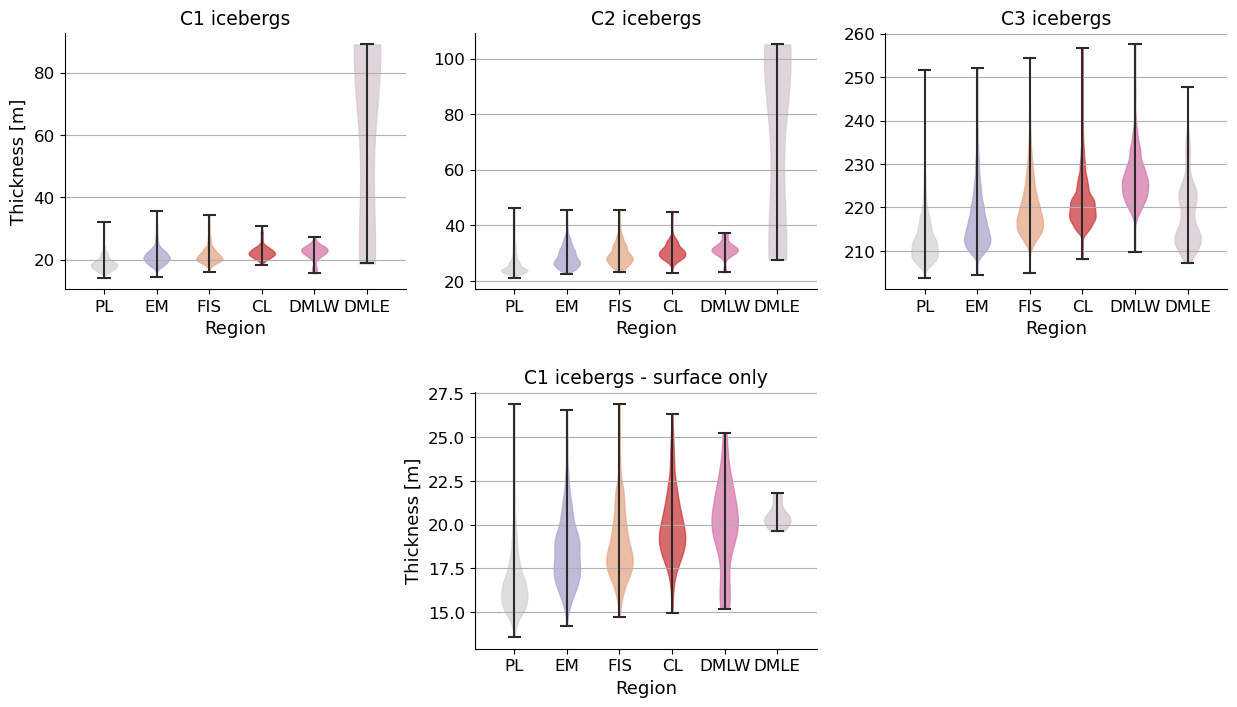

In [32]:
### Study thickness distribution in each coastal region - total range

# Prepare axes
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])                                          # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

# Plot thickness ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['thickness'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     [400,400]] ) # fill in values outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     prep[prep['region'] == 7]['thickness'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0 or i==4:
            ax.set_ylabel('Thickness [m]', fontsize=13)
        ax.tick_params(axis='y', which='both', labelsize=12)

        ax.spines[['right', 'top']].set_visible(False)   # hide right and top spines

    else:   # remove axes for empty plots
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Paper/FCbMinThicknessRegionsFull.pdf', bbox_inches='tight', dpi=300)
plt.show()

Supplements: Figure S3.4b

Plot C1s...
Plot C1a...
Saving figures...


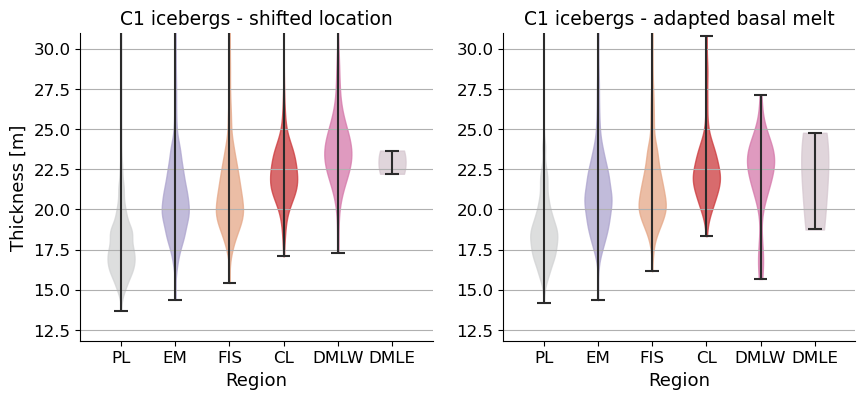

In [33]:
### Study thickness distribution in each coastal region

# Prepare axes
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1) # figure: 1 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1))
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1])]

# Plot mass ranges per simulation (violinplots)
i = 0
for prep, name, label, ax in zip(preps_sup, names_sup, labels_sup, axes):
    if type(prep)!=int:
        print(f'Plot {name}...')

        # Plot data
        if (len(prep[prep['region'] == 7]['thickness'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     [400,400]] ) # fill in values outside range when region 7 is empty or axis is removed from plot
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     prep[prep['region'] == 7]['thickness'].dropna().values] )
        
        # Set style violins
        for bd, col in zip(plts['bodies'], cols_carter):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        # Set axis style
        set_axis_style(ax, labs)

        ax.set_title(f'{label}', fontsize=13.5)
        ax.yaxis.grid(True)
        if i==0:
            ax.set_ylabel('Thickness [m]', fontsize=13)
        
        ax.set_ylim(12-(5/30), 31)                    
        ax.tick_params(axis='y', which='both', labelsize=12)

        ax.spines[['right', 'top']].set_visible(False) # hide right and top spines

    else:   # remove axes for empty plots
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Paper/FS06MinThicknessRegions.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Spatially

Now, study the distribution of the obtained (minimum) iceberg masses along the coast.

Main simulations: Figure 5b

In [34]:
### Load data
data = [C1b, C2b, C3b, 0, SB, 0]
names = ['C1', 'C2', 'C3', '-', 'SB', '-']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', '-', 'C1 icebergs - surface only', '-']

Start preparing C1...
   and plot...
Start preparing C2...
   and plot...
Start preparing C3...
   and plot...
Start preparing SB...
   and plot...
Saving figures...


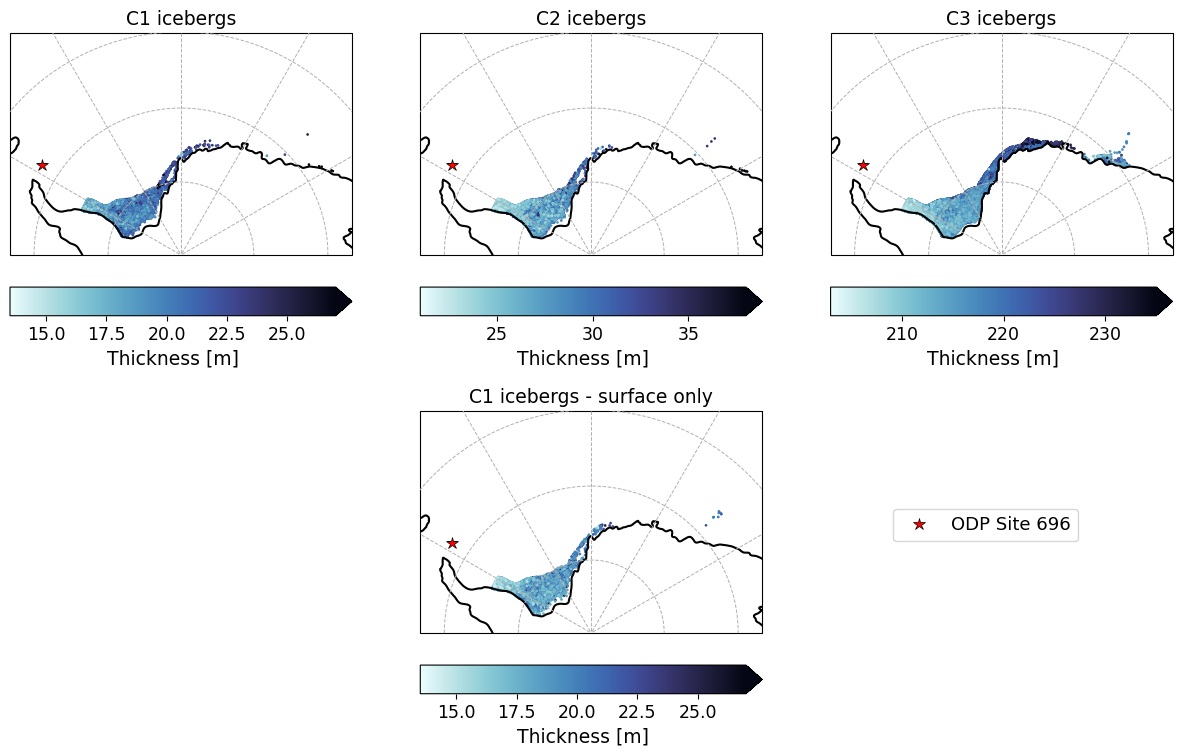

In [35]:
### Study thickness distribution spatially

# Prepare axes
fig = plt.figure(figsize=(15,9))

gs = GridSpec(2, 1, height_ratios=[1,1])                                                      # figure: 2 rows, 1 column
gs0 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1),
                              wspace=0.2, width_ratios=(1, 1, 1))                             # split top row: 1 row, 3 columns
gs1 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[1], hspace=0.0, height_ratios=(1, 0.1),
                              wspace=0.2, width_ratios=(1, 1, 1))                             # split bottom row: 1 row, 3 columns
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1], gs0[1,2], gs1[1,0], gs1[1,1], gs1[1,2])]

# Plot thickness per simulation
for dat, name, label, ax, c_ax in zip(data, names, labels, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        # Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        evot = (masked_dat['z'].values*(1027.5/850.))
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        # ODP 696
        ax.plot(x696_le, y696_le, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(),
                zorder=2)
        
        # Coastlines
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(),
                   colors='k', zorder=1)
        ax.scatter(1, -78.38, transform=ccrs.PlateCarree(), color='white', zorder=2, s=15)

        # Data
        if name=='C3':
            normalize = colors.Normalize(vmin=203, vmax=235)
        elif name=='C2':
            normalize = colors.Normalize(vmin=21, vmax=38)
        else:
            normalize = colors.Normalize(vmin=13.5, vmax=27)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=evot,
                        transform=ccrs.PlateCarree(), linewidth=.8, s=1.3, cmap=cmo.cm.ice_r, zorder=0, norm=normalize, rasterized=True)
        cbar = plt.colorbar(cf, cax=c_ax, orientation='horizontal', extend='max')
        cbar.set_label(label=r'Thickness [m]', size=13.5)
        cbar.ax.tick_params(labelsize=12.5)
        
        # Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])
        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        # Plot settings
        ax.set_title(f'{str(label)}', fontsize=13.5)
        
        if name == 'SB':
            handles, labels = ax.get_legend_handles_labels()
            ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                         markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
            handles.append(ODP)
            ax.legend(handles=handles, bbox_to_anchor=(1.95, .6), fontsize='13')
        
    else:   # remove axes for empty plots
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Paper/F05bMinThicknessSpatial.pdf', bbox_inches='tight', dpi=300)
plt.show()

Supplements: Figure S3.3b

In [36]:
### Load data
data_sup = [C1s, C1a]
names_sup = ['C1s', 'C1a']
labels_sup = ['C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

Start preparing C1s...
   and plot...
Start preparing C1a...
   and plot...
Saving figures...


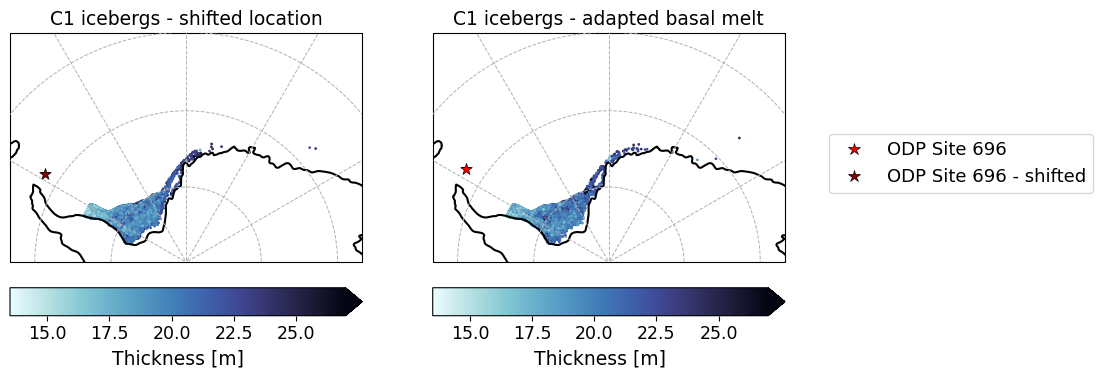

In [37]:
### Study thickness distribution spatially

# Prepare axes
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1)
gs0 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1))
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1])]

# Plot thickness per simulation
for dat, name, label, ax, c_ax in zip(data_sup, names_sup, labels_sup, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        # Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        evot = (masked_dat['z'].values*(1027.5/850.))
        print(f'   and plot...')
        
        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        # ODP 696
        if name == 'C1s':
            ax.scatter(x696_le-1, y696_le-0.5, color='darkred', marker='*', s=75, edgecolor='k', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        else:
            ax.scatter(x696_le, y696_le, color='r', marker='*', s=75, edgecolor='k', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        
        # Coastlines
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(),
                   colors='k', zorder=1)
        ax.scatter(1, -78.38, transform=ccrs.PlateCarree(), color='white', zorder=2, s=15)
        
        # Data
        normalize = colors.Normalize(vmin=13.5, vmax=27)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=evot,
                        transform=ccrs.PlateCarree(), linewidth=.8, s=1.3, cmap=cmo.cm.ice_r, norm=normalize, zorder=0, rasterized=True)
        cbar = plt.colorbar(cf, cax=c_ax, orientation='horizontal', extend='max')
        cbar.set_label(label=r'Thickness [m]', size=13.5)
        cbar.ax.tick_params(labelsize=12.5)
        
        # Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])
        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        # Plot settings
        ax.set_title(f'{str(label)}', fontsize=13.5)
        
        if name == 'C1a':
            handles, labels = ax.get_legend_handles_labels()
            ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                         markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
            handles.append(ODP)
            ODPs = Line2D([0], [0], label='ODP Site 696 - shifted', marker='*', markersize=np.sqrt(75),
                         markeredgecolor='k', markerfacecolor='darkred', markeredgewidth=.5, linestyle='')
            handles.append(ODPs)
            ax.legend(handles=handles, bbox_to_anchor=(1.9, .6), fontsize='13')
            
    else:   # remove axes for empty plots
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Paper/FS04bMinThicknessSpatial.pdf', bbox_inches='tight', dpi=300)
plt.show()